# Models of Neural Systems - Computer Practical 4
# Author: Robert Tjarko Lange

In [1]:
from __future__ import division
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, arange

## Question 1 - Synaptic Current

In [2]:
class linear_membrane_neuron():
    def __init__(self, synapse_type="Excitatory"):
        # Define General Membrane/Cell/Synapse Hyperparameters
        self.R_m = 10  # Membrane resistance - Converted to MO
        self.E_m = -80 # Cell membrane resting potential in mV
        self.I_e = 0  # External Current in mV

        self.tau_syn = 10  # synapse constant in msec
        self.tau_m = 10  # cell membrane constant in msec

        self.g_star = 30  # spike increase conductance in nS
        self.g_exc = 50  # excitatory synapse conductance in nS
        self.g_inh = 200  # inhibitory synapse conductance in nS

        self.E_syn = 0  # Synapse resting potential in mV - How to set in Shunting case?
        self.E_exc = 0  # Excitatory input cell resting potential in mV
        self.E_inh = -100  # Inhibitory input cell resting potential in mV

        self.t_spike = 10  # Time point of single spike in msec

        self.synapse_type = synapse_type  # Exc/Inh/Shunting synapse

        # Define Initial Conditions for Euler Approximation
        self.V_t = [-80]  # Membrane potential:  V_0 = -80 in mV
        self.g_syn_t = [0]  # Synaptic conductance: g_syn_0 = 0 in mV
        self.x_t = [0]  # Spike-helper function: x_0 = 0
        self.I_syn_t = [self.I_syn()]  # Synaptic current
        self.I_m_t = [self.I_m()]  # Membrane current

    def dV(self):
        # ODE describing membrane potential dynamics
        out = (-self.V_t[-1] + self.E_m
               - self.R_m*self.I_syn_t[-1] + self.R_m*self.I_e)
        return 1./self.tau_m * out

    def dx(self, t):
        # ODE describing spike-helper function dynamics
        out = (-self.x_t[-1] + self.tau_syn*self.g_star*(t==self.t_spike))
        return 1./self.tau_syn*out

    def dg_syn(self):
        # ODE describing synaptic conductace dynamics
        return 1./self.tau_syn*(self.x_t[-1]-self.g_syn_t[-1])

    def I_syn(self):
        # Synaptic current eq. - differentiate with Shunting inhibition case
        if self.synapse_type == "Shunting":
            syn_in = self.g_syn_t[-1]*(self.V_t[-1] - self.E_syn)
            exc_in = self.g_exc*(self.V_t[-1] - self.E_exc)
            inh_in = self.g_inh*(self.V_t[-1] - self.E_inh)
            return syn_in + exc_in + inh_in
        elif self.synapse_type == "Excitatory":
            return self.g_syn_t[-1]*(self.V_t[-1] - self.E_exc)
        elif self.synapse_type == "Inhibitory":
            return self.g_syn_t[-1]*(self.V_t[-1] - self.E_inh)
        else:
            raise ValueError("Provide an adequate synapse type as input")

    def I_m(self):
        # Membrane current equation
        return (self.V_t[-1] - self.E_m)/self.R_m

    def run_euler(self, t_max, dt):
        # Computes euler approximation to ODE solution
        t_seq = np.arange(dt, t_max, dt)

        for t in t_seq:
            self.V_t.append(self.V_t[-1] + self.dV()*dt)
            self.g_syn_t.append(self.g_syn_t[-1] + self.dg_syn()*dt)
            self.x_t.append(self.x_t[-1] + self.dx(t))

            self.I_syn_t.append(self.I_syn())
            self.I_m_t.append(self.I_m())

            # print(self.V_t[-1], self.g_syn_t[-1], self.x_t[-1], self.I_syn_t[-1], self.I_m_t[-1])

        self.t_seq = np.insert(t_seq, 0, 0)

    def get_euler_output(self):
        # Returns euler output
        return self.t_seq, self.V_t, self.g_syn_t, self.I_syn_t, self.I_m_t


In [3]:
def plot_voltage_Q1(t_seq, V_t, g_syn_t, I_syn_t, I_m_t, t_spike, title):
    # Plot voltage/membrane dynamics for Question 1
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
            
    # Plots the quantities of interest
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (mSec)')
    ax1.set_ylabel('mV')
    lns_1 = ax1.plot(t_seq, V_t, label=r"$V_t$ (mV)", c="blue")

    for xc in t_spike:
        ax1.axvline(x=xc, alpha=0.5, c="black", linestyle="--")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('nS')  # we already handled the x-label with ax1
    lns_2 = ax2.plot(t_seq, g_syn_t, label=r"$g_{syn}(t)$ (nS)", c="green")

    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(ax3)
    ax3.spines["right"].set_visible(True)

    ax3.set_ylabel('nA')  # we already handled the x-label with ax1
    lns_3 = ax3.plot(t_seq, I_syn_t, label=r"$I_{syn}(t)$ (nA)", c="red")
    lns_4 = ax3.plot(t_seq, I_m_t, label=r"$I_{m}(t)$ (nA)", c="yellow")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    lns = lns_1 + lns_2 + lns_3 + lns_4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=7)
    plt.title(title, fontsize=10)
    plt.show()

In [4]:
# Calculate Euler Approximation for 3 different synapse types
neuron_test_exc = linear_membrane_neuron("Excitatory")
neuron_test_exc.run_euler(t_max=100, dt=0.01)
t_seq_exc, V_t_exc, g_syn_t_exc, I_syn_t_exc, I_m_t_exc = neuron_test_exc.get_euler_output()

neuron_test_inh = linear_membrane_neuron("Inhibitory")
neuron_test_inh.run_euler(t_max=100, dt=0.01)
t_seq_inh, V_t_inh, g_syn_t_inh, I_syn_t_inh, I_m_t_inh = neuron_test_inh.get_euler_output()

neuron_test_exc = linear_membrane_neuron("Shunting")
neuron_test_exc.run_euler(t_max=100, dt=1)
t_seq_sh, V_t_sh, g_syn_t_sh, I_syn_t_sh, I_m_t_sh = neuron_test_exc.get_euler_output()

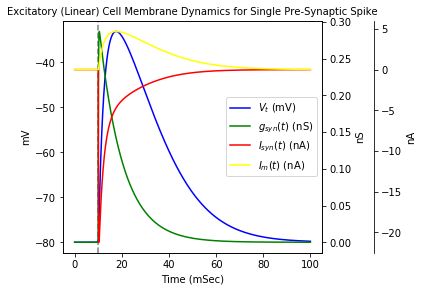

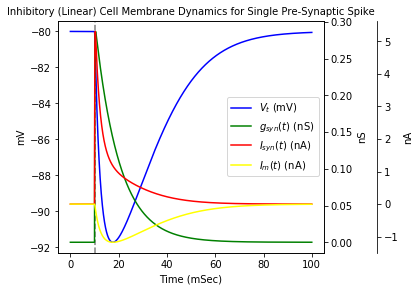

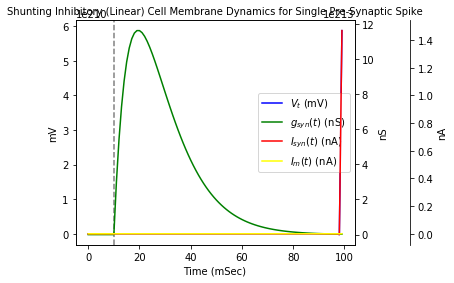

In [5]:
# Plot results of Euler Approximation
t_spike = [10]
plot_voltage_Q1(t_seq_exc, V_t_exc, g_syn_t_exc, I_syn_t_exc, I_m_t_exc, t_spike, "Excitatory (Linear) Cell Membrane Dynamics for Single Pre-Synaptic Spike")

plot_voltage_Q1(t_seq_inh, V_t_inh, g_syn_t_inh, I_syn_t_inh, I_m_t_inh, t_spike, "Inhibitory (Linear) Cell Membrane Dynamics for Single Pre-Synaptic Spike")

plot_voltage_Q1(t_seq_sh, V_t_sh, g_syn_t_sh, I_syn_t_sh, I_m_t_sh, t_spike, "Shunting Inhibitory (Linear) Cell Membrane Dynamics for Single Pre-Synaptic Spike")

Plots of excitatory and inhibitory cell correspond to intuition:

* For exctitatory cell: Presynaptic spike leads to rapid increase in membrane potential (depolarization) due to a positive synaptic current which is followed by an exponential decay (repolarization) phase until the resting potential is reached again. We do not model an overshoot/hyperpolarization.

* For inhibtory cell: Presynaptic spike leads to rapid decrease in membrane potential due to a negative synaptic current which is followed by an exponential increase until the resting potential is reached again. We do not model an overshoot/hyperpolarization.

For both cases we can observe that the synaptic conductance increases with the spike and decreases afterwards again.

How to choose $E_{syn}$? - Would have loved to get some response to my question posted in Forum.

## Question 2 - Integrate-and-Fire Neuron

In [6]:
class lif_neuron():
    def __init__(self, I_e=3):
        # Define General Membrane/Cell/Synapse Hyperparameters
        self.R_m = 10  # Membrane resistance - Converted to MO
        self.E_m = -80 # Cell membrane resting potential in mV
        self.I_e = I_e  # External Current in mV

        self.tau_m = 10  # cell membrane constant in msec

        self.I_syn = 0
        self.V_thresh = -54  # Threshold membrane potential
        self.V_reset = -80  # Reset membrane potential after spike

        # Define Initial Conditions for Euler Approximation
        self.V_t = [random.uniform(self.V_reset, self.V_thresh)]  # Membrane potential:  V_0 random init in mV

        self.t_spike = [0]  # List storing time points of spikes
        self.inv_ISIs = []  # List storing interstimulus time intervals
        self.FRs = [] # List storing the estimated firing rates

    def dV(self):
        # ODE describing membrane potential dynamics
        out = (-self.V_t[-1] + self.E_m
               - self.R_m*self.I_syn + self.R_m*self.I_e)
        return 1./self.tau_m * out

    def run_euler(self, t_max, dt):
        # Computes euler approximation to ODE solution
        t_seq = np.arange(dt, t_max, dt)
        max_iter = len(t_seq)
        t = 0

        while t <= (max_iter-1):
            V_step = self.V_t[-1] + self.dV()*dt
            if V_step > self.V_thresh:
                # If threshold is exceeded - reset and keep MP at rest for reset time
                self.V_t += int(len(self.t_spike)/dt + 1)*[self.V_reset]

                # Update spiking statistics
                self.t_spike.append(t*dt)
                self.inv_ISIs.append(1./(self.t_spike[-1] - self.t_spike[-2]))
                self.FRs.append(len(self.t_spike)/self.t_spike[-1])
            else:
                self.V_t.append(V_step)
            t = len(self.V_t) - 1

        self.t_seq = np.insert(t_seq, 0, 0)

    def get_euler_output(self):
        # Returns euler output
        return self.t_seq, self.V_t[0:len(self.t_seq)], self.t_spike[1:], self.inv_ISIs, self.FRs

    def calc_ana_mean_firing_rate(self):
        temp = (self.R_m*self.I_e + self.E_m - self.V_reset)/(self.R_m*self.I_e + self.E_m - self.V_thresh)
        log_ratio = np.log(temp)
        return 1./(self.tau_m*log_ratio)

In [7]:
def plot_voltage(t_seq, V_t, t_spike, title):
    # Plots the quantities of interest
    plt.xlabel('Time (mSec)')
    plt.ylabel('Membrane Potential (mV)')
    plt.plot(t_seq, V_t, c="blue")

    for xc in t_spike:
        plt.axvline(x=xc, alpha=0.5, c="black", linestyle="--")

    plt.title(title, fontsize=10)
    plt.show()


def plot_firing_rate(in_current, mean_FR_ana, mean_FR_FR, mean_FR_ISI):
    # Plots the quantities of interest
    plt.xlabel('Input Current (nA)')
    plt.ylabel(r'$r_0(I_e)$')
    plt.plot(in_current, mean_FR_ana, c="blue", label="Analytical")
    plt.plot(in_current, mean_FR_FR, c="red", label="Firing Rate-Based")
    plt.plot(in_current, mean_FR_ISI, c="green", label="ISI-Based")
    plt.title("Mean Firing Rate for Different Input Currents", fontsize=10)
    plt.legend()
    plt.show()

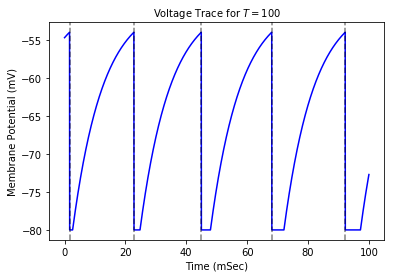

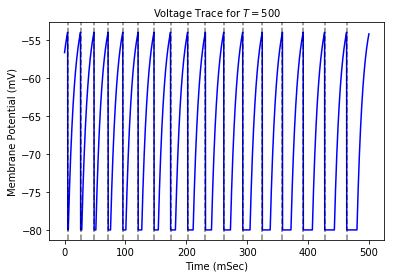

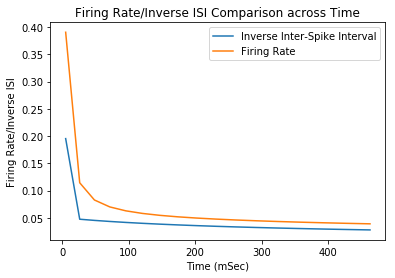

In [8]:
# Run simple integrate and fire neuron model for T=100 and T=500
neuron_test = lif_neuron()
neuron_test.run_euler(100, 0.01)
t_seq, V_t, t_spike, inv_ISIs, FRs = neuron_test.get_euler_output()
# Plot Voltage Trace T=100
plot_voltage(t_seq, V_t, t_spike, r"Voltage Trace for $T=100$")

neuron_test = lif_neuron()
neuron_test.run_euler(500, 0.01)
t_seq, V_t, t_spike, inv_ISIs, FRs = neuron_test.get_euler_output()
# Plot Voltage Trace T=500
plot_voltage(t_seq, V_t, t_spike, r"Voltage Trace for $T=500$")

# Plot Firing Rate/ISI over time
plt.plot(t_spike, inv_ISIs, label="Inverse Inter-Spike Interval")
plt.plot(t_spike, FRs, label="Firing Rate")
plt.xlabel("Time (mSec)")
plt.ylabel("Firing Rate/Inverse ISI")
plt.legend()
plt.title("Firing Rate/Inverse ISI Comparison across Time")
plt.show()

In limit both both quantities seem to converge! In beginning the firing rate is higher than the ISI. This is most certainly due to the way in which we model the resetting time (number of spikes as mSecs). 

/Users/rtl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in log


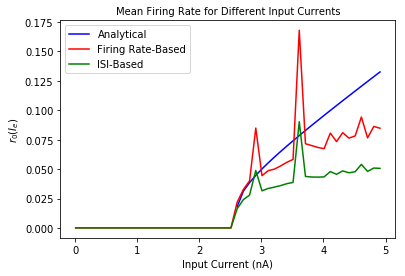

In [9]:
# Calculate Firing Rates for a range of external currents
in_current = np.arange(0.01, 5, 0.1)
mean_FR_FR = []
mean_FR_ISI = []
mean_FR_ana = []

for I_e in in_current:
    neuron_test = lif_neuron(I_e)
    neuron_test.run_euler(1000, 0.01)
    t_seq, V_t, t_spike, inv_ISIs, FRs = neuron_test.get_euler_output()
    mean_FR_ana.append(neuron_test.calc_ana_mean_firing_rate())
    if len(t_spike) == 0:
        mean_FR_FR.append(0)
        mean_FR_ISI.append(0)
    else:
        mean_FR_FR.append(sum(FRs)/len(FRs))
        mean_FR_ISI.append(sum(inv_ISIs)/len(inv_ISIs))

plot_firing_rate(in_current, mean_FR_ana, mean_FR_FR, mean_FR_ISI)

Approximation is exact for all input currents below 2.5. Afterwards both firing rate-based and inverse ISI-based approximations seem to be downwards biased. This could be due to the fact that we only average over a spike train obtained over 1000 mSecs.

* Interpretation: For an external current below 2.5 nA the excitatory cell is not reaching the threshold and thus it does not depolarize. As the external current increases the firing rate increases as well.

* Real neuron comment: In reality the analytical mean firing rate should be noisy due to stochasticity in generel cell physiology/morphology.

## Question 3 - Synaptically coupled IF neurons

In [10]:
class syn_coupled_if_neuron():
    def __init__(self, V_0, synapse_type="Excitatory",
                 I_e=3.5, g_star=30, tau_syn=10):
        # Define General Membrane/Cell/Synapse Hyperparameters
        self.R_m = 10  # Membrane resistance - Converted to MO
        self.E_m = -70 # Cell membrane resting potential in mV
        self.I_e = I_e  # External Current in mV

        self.tau_syn = 10  # synapse constant in msec
        self.tau_m = 10  # cell membrane constant in msec

        self.g_star = g_star  # spike increase conductance in nS
        self.g_exc = 50  # excitatory synapse conductance in nS
        self.g_inh = 200  # inhibitory synapse conductance in nS

        self.E_exc = 0  # Excitatory input cell resting potential in mV
        self.E_inh = -100  # Inhibitory input cell resting potential in mV
        self.synapse_type = synapse_type  # Exc/Inh/Shunting synapse

        self.V_thresh = -54  # Threshold membrane potential
        self.V_reset = -80  # Reset membrane potential after spike

        # Define Initial Conditions for Euler Approximation
        self.V_t = [V_0]  # Membrane potential:  V_0 = -80 in mV
        self.g_syn_t = [0]  # Synaptic conductance: g_syn_0 = 0 in mV
        self.x_t = [0]  # Spike-helper function: x_0 = 0
        self.I_syn_t = [self.I_syn()]  # Synaptic current in nA

        self.t_spike = []  # List storing time points of spikes
        self.t = 0  # Initialize time counter

    def dV(self):
        # ODE describing membrane potential dynamics
        out = (-self.V_t[-1] + self.E_m
               - self.R_m*self.I_syn() + self.R_m*self.I_e)
        return 1./self.tau_m * out

    def dx(self, spike_ind):
        # ODE describing spike-helper function dynamics
        out = (-self.x_t[-1] + self.tau_syn*self.g_star*(spike_ind))
        return 1./self.tau_syn*out

    def dg_syn(self):
        # ODE describing synaptic conductace dynamics
        return 1./self.tau_syn*(self.x_t[-1]-self.g_syn_t[-1])

    def I_syn(self):
        if self.synapse_type == "Excitatory":
            return self.g_syn_t[-1]*(self.V_t[-1] - self.E_exc)
        elif self.synapse_type == "Inhibitory":
            return self.g_syn_t[-1]*(self.V_t[-1] - self.E_inh)
        else:
            raise ValueError("Provide an adequate synapse type as input")

    def euler_step(self, dt, spike_ind):
        # Computes one euler step - return boolean True if spike occurs
        self.t += 1
        V_step = self.V_t[-1] + self.dV()*dt
        self.g_syn_t.append(self.g_syn_t[-1] + self.dg_syn()*dt)
        self.x_t.append(self.x_t[-1] + self.dx(spike_ind))
        self.I_syn_t.append(self.I_syn())

        if V_step > self.V_thresh:
            # If threshold is exceeded - reset and keep MP at rest for reset time
            reset_time = int(len(self.t_spike)/dt + 1)
            self.V_t += reset_time*[self.V_reset]
            # Update spiking statistics
            self.t_spike.append(self.t*dt)
            self.t = len(self.V_t) - 1
            spike = True
        else:
            self.V_t.append(V_step)
            spike = False
        return spike

    def get_euler_output(self):
        # Returns euler output
        return self.V_t, self.t_spike


def run_coupled_neurons(t_max=50, synapse_type="Excitatory",
                        I_e=3.5, g_star=30, tau_syn=10):
    # Create two neuron instance and alternate in updates
    neuron_1 = syn_coupled_if_neuron(V_0=-80, synapse_type=synapse_type,
                                     I_e=I_e, g_star=g_star, tau_syn=tau_syn)
    neuron_2 = syn_coupled_if_neuron(V_0=-54, synapse_type=synapse_type,
                                     I_e=I_e, g_star=g_star, tau_syn=tau_syn)

    dt = 0.01
    t_seq = np.arange(dt, t_max, dt)
    max_iter = len(t_seq)

    spike_2 = True

    while neuron_1.t <= (max_iter-1) or neuron_2.t <= (max_iter-1):
        spike_1 = neuron_1.euler_step(dt, spike_2)
        spike_2 = neuron_2.euler_step(dt, spike_1)

    V_t_1, t_spike_1 = neuron_1.get_euler_output()
    V_t_2, t_spike_2 = neuron_2.get_euler_output()
    return t_seq, V_t_1[0:len(t_seq)], [sp for sp in t_spike_1 if sp<=t_max], V_t_2[0:len(t_seq)], [sp for sp in t_spike_2 if sp<=t_max]

In [11]:
def plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2, title):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    fig.suptitle(title, fontsize=12)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    ax[0].plot(t_seq, V_t_1)
    for xc in t_spike_1:
        ax[0].axvline(x=xc, alpha=0.5, c="black", linestyle="--")
    ax[0].set_xticks(())
    ax[0].set_title(r"Membrane Potential Neuron 1: $V_0 = V_{rest}$")
    ax[0].set_ylabel(r"mV")

    ax[1].plot(t_seq, V_t_2)
    for xc in t_spike_2:
        ax[1].axvline(x=xc, alpha=0.5, c="black", linestyle="--")
    ax[1].set_title(r"Membrane Potential Neuron 2: $V_0 = V_{thresh}$")
    ax[1].set_xlabel(r"Time (mSec)")
    ax[1].set_ylabel(r"mV")
    plt.show()

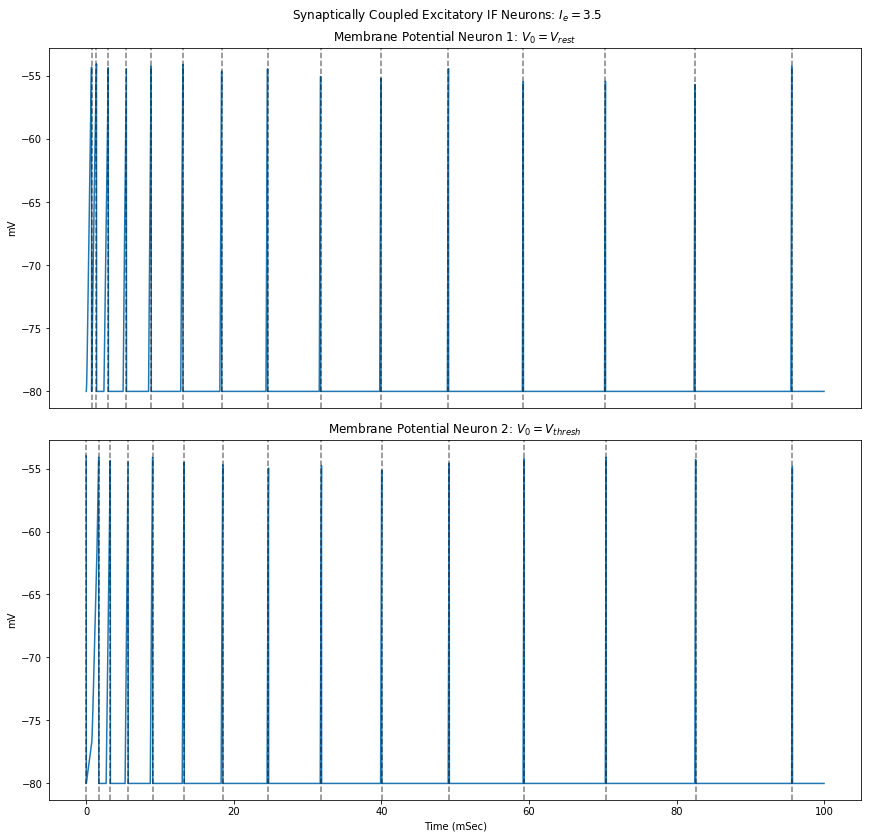

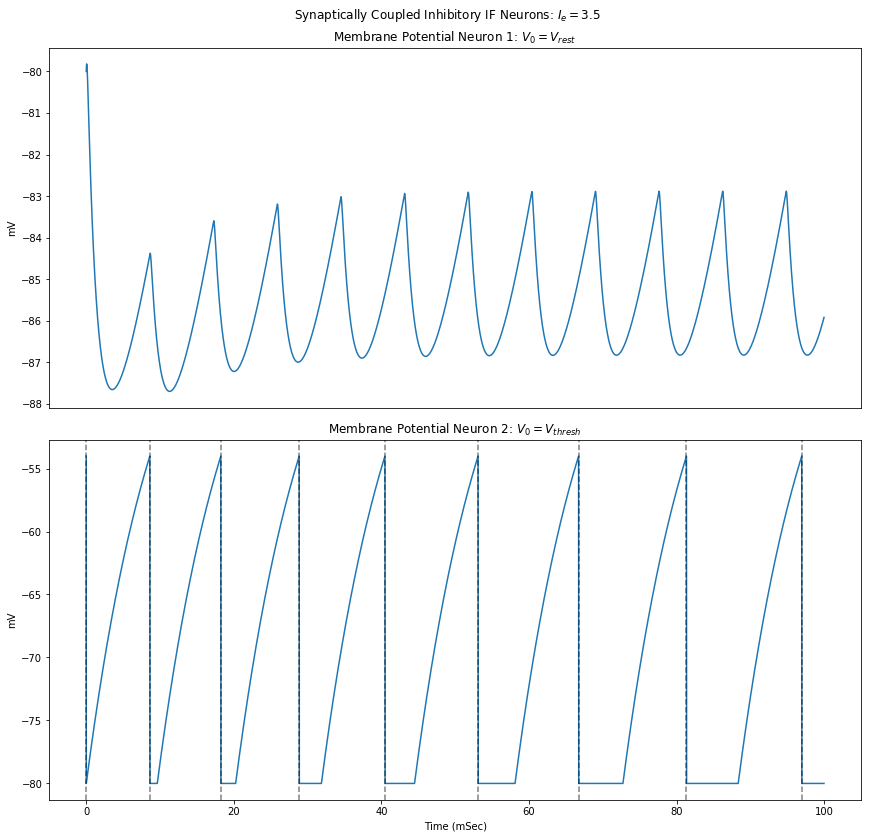

In [12]:
# Basic Plots - I_e=3.5
t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Excitatory")

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Excitatory IF Neurons: $I_e = 3.5$")

t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Inhibitory")

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Inhibitory IF Neurons: $I_e = 3.5$")

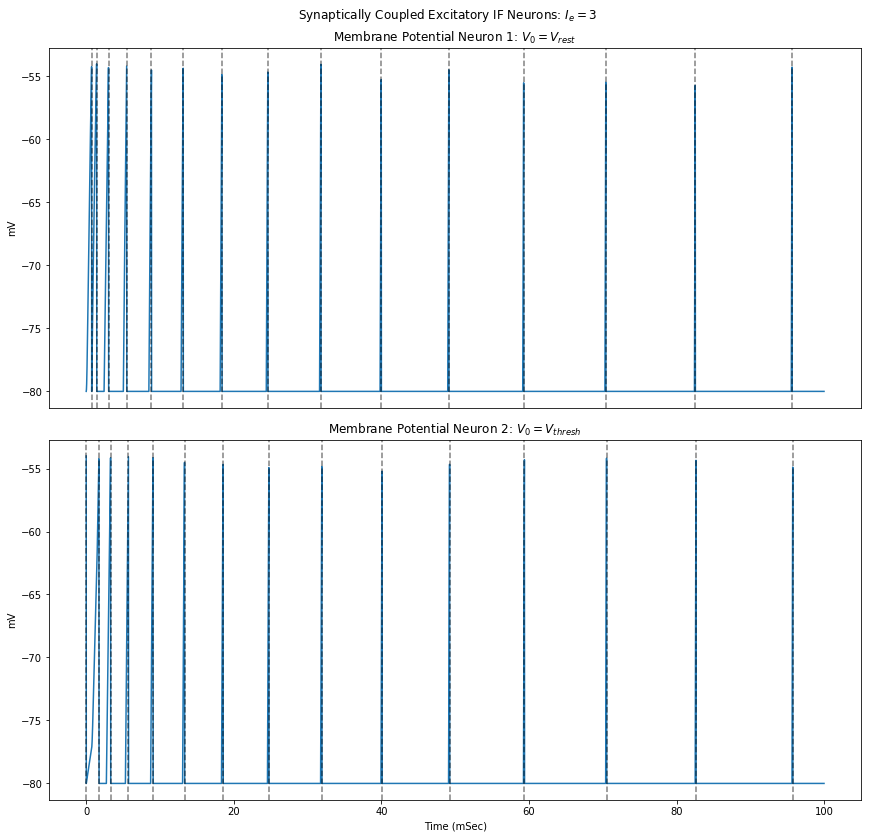

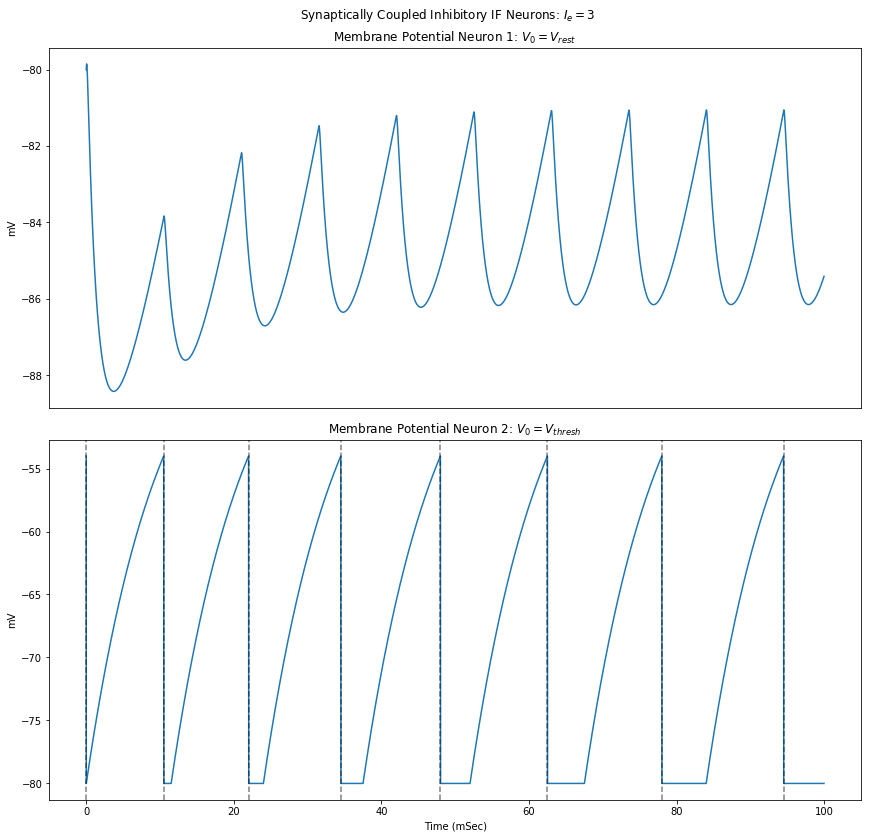

In [13]:
# Plots - Lower external current I_e=3
t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Excitatory", I_e=3)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Excitatory IF Neurons: $I_e = 3$")

t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Inhibitory", I_e=3)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Inhibitory IF Neurons: $I_e = 3$")

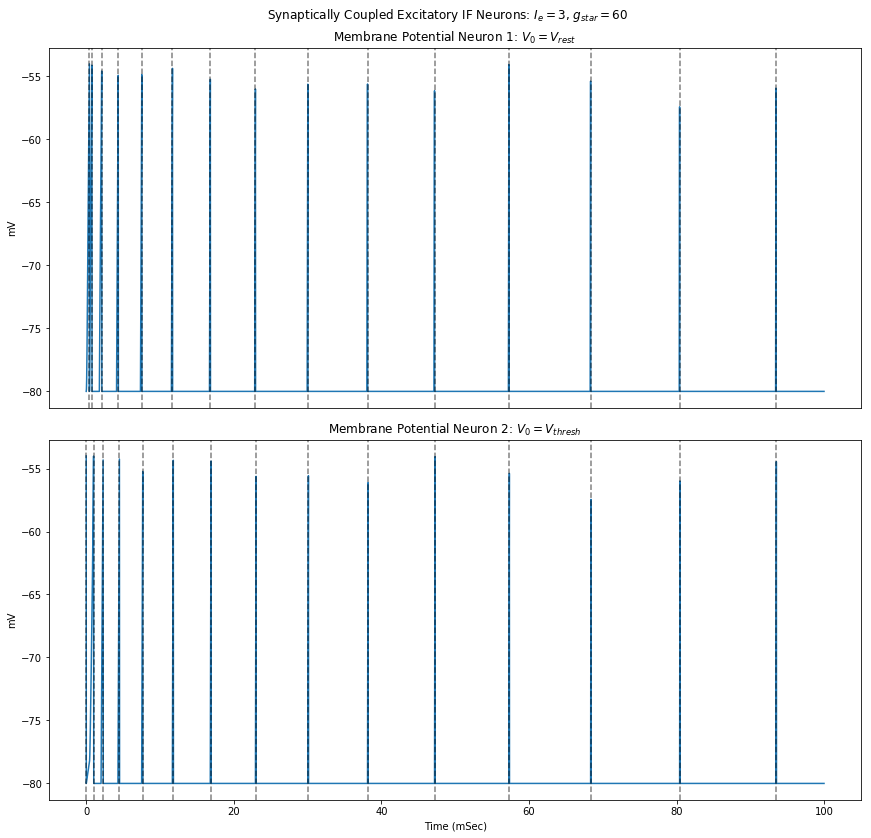

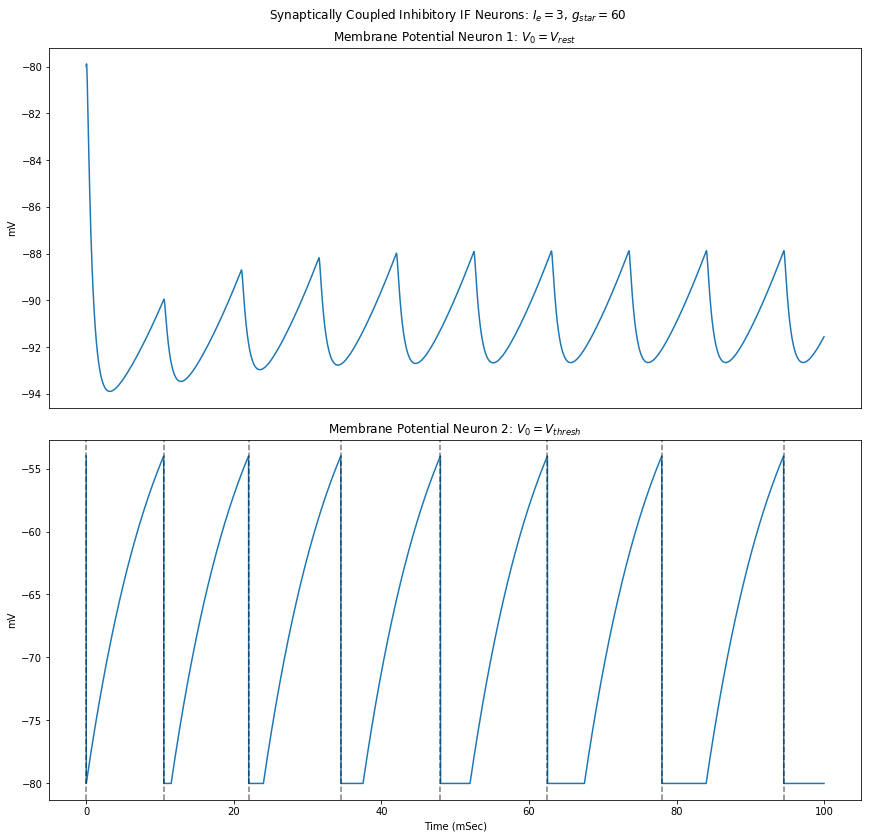

In [14]:
# Plots - Lower external current I_e=3, g_star = 60
t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Excitatory", I_e=3,
                                                                g_star=60)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Excitatory IF Neurons: $I_e = 3$, $g_{star}=60$")

t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Inhibitory", I_e=3,
                                                                g_star=60)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Inhibitory IF Neurons: $I_e = 3$, $g_{star}=60$")

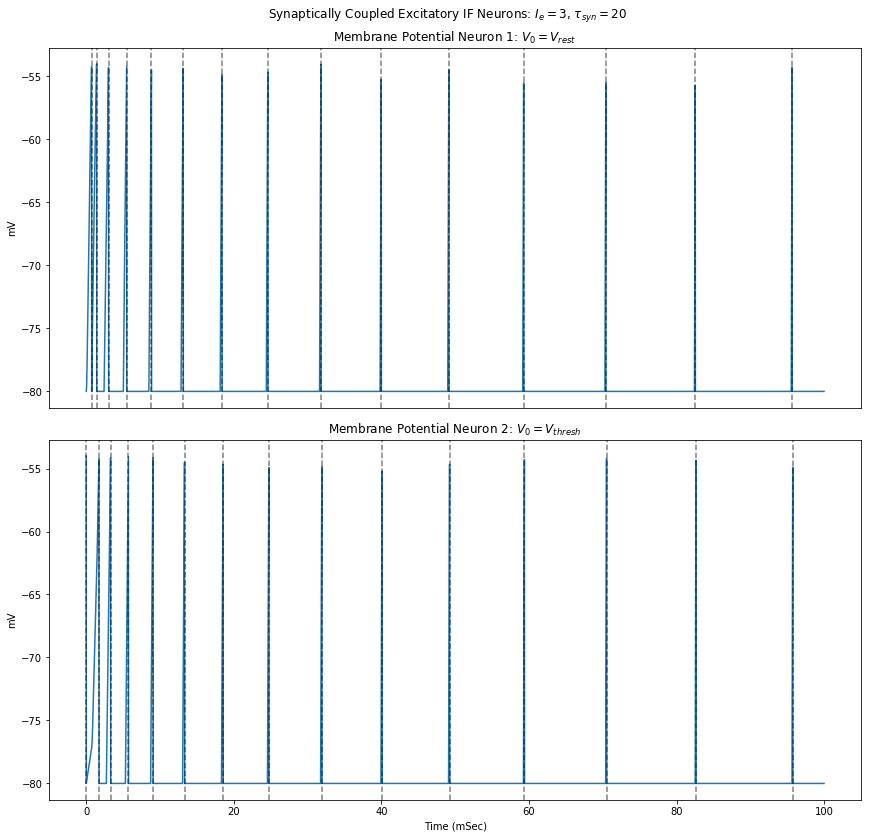

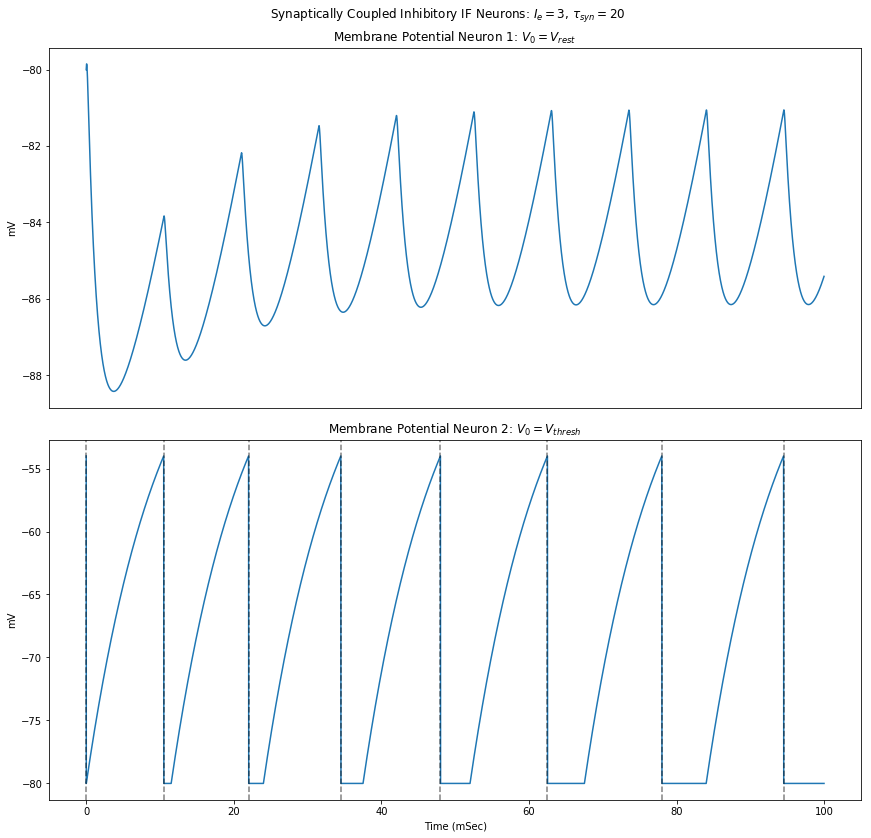

In [15]:
# Plots - Lower external current I_e=3, tau_syn = 20
t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Excitatory", I_e=3,
                                                                tau_syn=20)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Excitatory IF Neurons: $I_e = 3$, $\tau_{syn}=20$")

t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2 = run_coupled_neurons(100, "Inhibitory", I_e=3,
                                                                tau_syn=20)

plot_coupled_neurons(t_seq, V_t_1, t_spike_1, V_t_2, t_spike_2,
                     r"Synaptically Coupled Inhibitory IF Neurons: $I_e = 3$, $\tau_{syn}=20$")

* General Observations:
    * Excitatory coupled neuron: Spike in one neuron facilitates spiking behavior in the other. In the beginning, the timing between a spike in neuron 1 and 2 is not fully synchronized. As time develops they become better and better synchronized.
    * Inhibitory coupled neuron: Spike in one neuron inhibitis spiking behavior in the other. The neuron which is set to spike at $t=0$ builds up its membrane potential due to external current while the other one is cyclically inhibited in its potential build up.
    
* Change in $I_e \downarrow$: Less spikes/decreased firing rate.
* Change in $g^{\star} \uparrow$, Change in $\tau_{syn} \uparrow$: Faster synchronization